# Inspect results

Models ablation study [HERE ON COLAB](https://colab.research.google.com/drive/1d1uy8A10ZJgGL_A6sh0osTF_M0-dgwaQ?usp=sharing)

In [9]:
# Prediction margin: the only parameter to set. Recommended: margin in {5, 10, 15, 20} (aka 0.5, 1, 1.5, 2 seconds)
margin = 15

In [10]:
import pickle
import os
import matplotlib.pyplot as plt

mean = lambda l: sum(l) / len(l)

In [11]:
BASE_FP = 0.2
BASE_FN = 1


def false_positive_cost(i, is_fault, fault_found):
    return BASE_FP


def false_negative_cost(i, is_fault, fault_found):
    if not fault_found:
        for j in range(1, margin + 1):
            if i + j < is_fault.shape[0] and not is_fault[i + j] or i + j >= is_fault.shape[0]:
                return (margin + 1 - j) * BASE_FN
    else:
        return 0


def performance_evaluation(signal, thr, rul):
    fp, fn, tp, tot_p = 0, 0, 0, 0
    cost = 0
    alarm = (signal >= thr)
    anticipation = []
    is_fault = (rul == 0)
    
    fault_found = False
    for i in range(len(rul)):
        if i > 0 and is_fault[i] and not is_fault[i - 1]:
            tot_p += 1
            start = i
        if is_fault[i] and not fault_found and alarm[i]:
            tp += 1
            fault_found = True
            anticipation.append((margin - 1) - (i - start))
        if (i < len(rul) - 1 and is_fault[i] and not is_fault[i + 1] and not fault_found) or (i == len(rul) - 1 and not fault_found):
            fn += 1 
        if is_fault[i] and signal[i] <= thr:
            cost += false_negative_cost(i, is_fault, fault_found)
        if not is_fault[i]:
            fault_found = False
            if alarm[i]:
                fp += 1
                cost += false_positive_cost(i, is_fault, fault_found)
        
    tot_a = sum(anticipation) / 10
    if sum(anticipation) > 0:
        mean_a = mean(anticipation) / 10
    else:
        mean_a = 0
    
    return [cost, mean_a, tp, fn, fp]


def plot_threshold(signal, thr, rul):

    plt.plot(signal, alpha=0.5)
    plt.plot(range(len(signal)), [thr] * len(signal))

    ranges = []
    signal_values = []
    for i in range(len(rul)):
        if rul[i] == 0:
            ranges.append(i)
            signal_values.append(signal[i])

    plt.scatter(ranges, signal_values, color="red", s=10)
    
    # plt.ylim(0, 0.0001)
    plt.title("Alarm signal & threshold")
    plt.ylabel('Alarm signal intensity')
    plt.xlabel('Time')
    plt.legend(['Alarm signal', "Threshold", 'Anomalies'], loc='upper right')
    plt.show()
    plt.show()

In [12]:
file = "conv_nn-w5_features-s100-p0"

Traning summary of the model.

Model:		 conv_nn
Features:	 w5_features
Seed:		 s100
Params_idx:	 p0
Params:		 {'filters': 1, 'kernel_size': 3, 'hidden': [32], 'w_len': 5}
Best_cost:	 0
Best_threshold:	 0.005025125628140704

Metrics computed on TEST set:

Cost:		 0
Anticipation:	 1.4
Detect_faults:	 13
Missed_faults:	 0
False_alarms:	 0


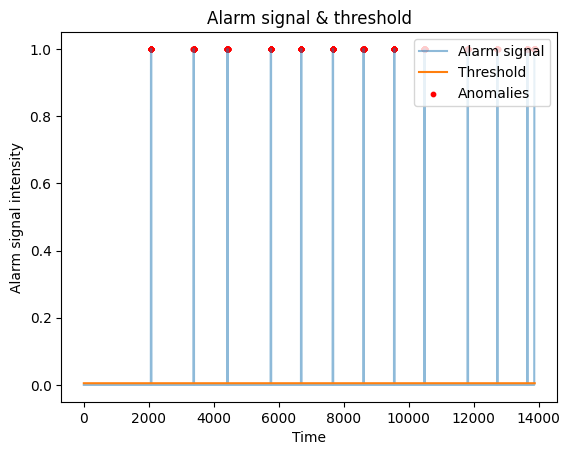


Metrics computed on VALIDATION set:

Cost:		 0
Anticipation:	 1.4
Detect_faults:	 7
Missed_faults:	 0
False_alarms:	 0


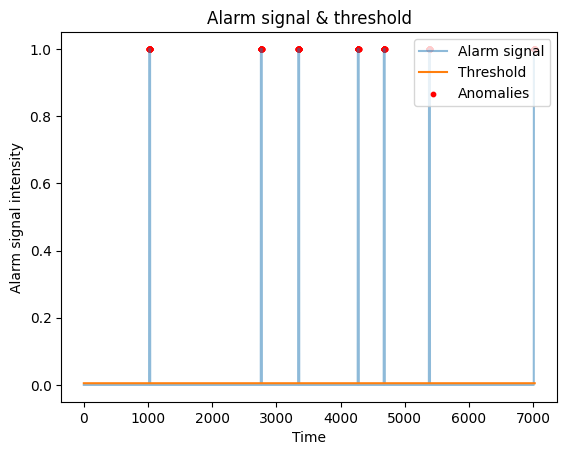

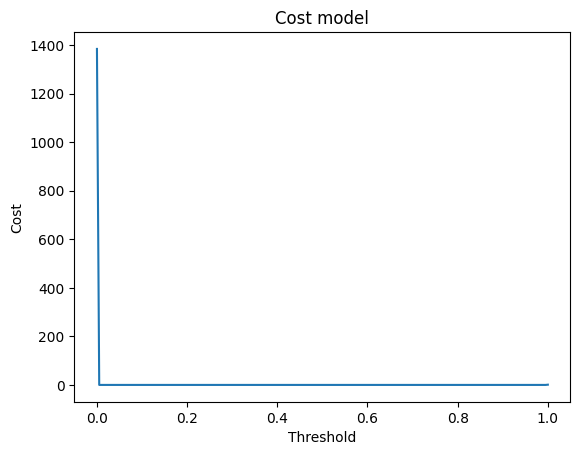

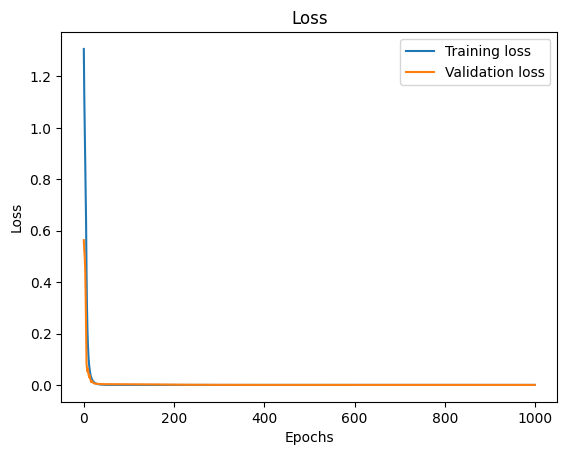

In [13]:
with open("results_" + str(margin) + "/" + file, "rb") as f:
    with open("threshold_" + str(margin) + "/" + file, "rb") as f2:
        with open("threshold_" + str(margin) + "/val_" + file, "rb") as f3:
    
            model, feature, seed, params_idx = file.split("-")
            training_columns, params, history, best_cost, best_thr, all_cost, all_thr, perf = pickle.load(f)
            cost, ant, df, mf, fa = perf

            test_signal, best_thr, test_rul = pickle.load(f2)
            test_cost, test_ant, test_df, test_mf, test_fa = performance_evaluation(test_signal, best_thr, test_rul)

            val_signal, val_best_thr, val_rul = pickle.load(f3)

            print("Traning summary of the model.\n")
            print("Model:\t\t", model)
            print("Features:\t", feature)
            print("Seed:\t\t", seed)
            print("Params_idx:\t", params_idx)
            print("Params:\t\t", params)
            print("Best_cost:\t", best_cost)
            print("Best_threshold:\t", best_thr)

            print("\nMetrics computed on TEST set:\n")
            print("Cost:\t\t", test_cost)
            print("Anticipation:\t", test_ant)
            print("Detect_faults:\t", test_df)
            print("Missed_faults:\t", test_mf)
            print("False_alarms:\t", test_fa)

            plot_threshold(test_signal, best_thr, test_rul)

            print("\nMetrics computed on VALIDATION set:\n")
            print("Cost:\t\t", cost)
            print("Anticipation:\t", ant)
            print("Detect_faults:\t", df)
            print("Missed_faults:\t", mf)
            print("False_alarms:\t", fa)

            plot_threshold(val_signal, val_best_thr, val_rul)

            plt.title("Cost model")
            plt.plot(all_thr, all_cost)
            # plt.ylim(-0.2, 5)
            plt.ylabel('Cost')
            plt.xlabel('Threshold')
            plt.show()

            if history is not None:
                plt.title("Loss")
                #plt.ylim(0, 0.0001)
                plt.plot(history.history["loss"])
                plt.plot(history.history["val_loss"])
                plt.ylabel('Loss')
                plt.xlabel('Epochs')
                plt.legend(['Training loss', "Validation loss"], loc='upper right')
                plt.show()
